# Identifying ROIs in Sankey Branches

Using the Sankey diagram at the subject level, we found certain branches. In the Sankey diagram, the
branch was an estimate of how many nodes switched and we lost the information of *which* nodes switched
community assignments. Therefore, here we will implement a way to find which of those nodes actually switched.
To do this, we have to consider the number of cycles that the switch occurred.

In [3]:
import numpy as np
import importlib
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import OAM_functions as ov_func
import Towlson_group_code.data_io as myFunc
import surfer_customizer as surfer

FIG_PATH = '../../Ovarian_hormone/Figures/'
PICKLE_PATH = '../../Ovarian_hormone/pickles/'

all_cycles = myFunc.load_from_pickle('../../Ovarian_hormone/pickles/', 'all_cycles.pkl')
ef_input_params = myFunc.load_from_pickle("../../Ovarian_hormone/pickles/individual_connectomes/",
                                          "ef_input_params.pkl")

ef_name_to_idx = {x[0]: x[1] for x in ef_input_params.values()}

def get_cycle_adj_matrices(ci):
    ef_scan, lf_scan, ml_scan = all_cycles[ci]
    idx = ef_name_to_idx[ef_scan+'.pkl']
    a1 = myFunc.load_from_pickle(f'../../Ovarian_hormone/pickles/individual_connectomes/{idx}/', ef_scan+'.pkl')
    a2 = myFunc.load_from_pickle(f'../../Ovarian_hormone/pickles/individual_connectomes/{idx}/', lf_scan+'.pkl')
    a3 = myFunc.load_from_pickle(f'../../Ovarian_hormone/pickles/individual_connectomes/{idx}/', ml_scan+'.pkl')
    return [a1, a2, a3]

def get_cycle_partitions(ci):
    ef_scan, lf_scan, ml_scan = all_cycles[ci]
    a1 = myFunc.load_from_pickle(f'../../Ovarian_hormone/pickles/best_subject_auditory/', ef_scan+'_auditory.pkl')
    a2 = myFunc.load_from_pickle(f'../../Ovarian_hormone/pickles/hypothesis_tested/',
                                 f'cycle_{ci}_LF_partition_auditory_EF.pkl')
    a3 = myFunc.load_from_pickle(f'../../Ovarian_hormone/pickles/hypothesis_tested/',
                                 f'cycle_{ci}_ML_partition_auditory_LF.pkl')
    return [a1, a2, a3]

int_to_phase = {0: 'EF', 1: 'LF', 2: 'ML'}
phase_to_int = {'EF': 0, 'LF': 1, 'ML': 2}

Enter the phase transition (src and destination) and which functional network to check

In [6]:
src_phase = 'EF'
dest_phase = 'LF'
src_icn = 6
dest_icn = 0

Lim --> DMN between EF and LF
Cycle 0: 16.7% moved (8 / 48 nodes)
Cycle 2: 16.7% moved (4 / 24 nodes)
Cycle 4: 25.0% moved (33 / 132 nodes)
Cycle 5: 0.0% moved (0 / 19 nodes)
Cycle 7: 45.9% moved (28 / 61 nodes)
Cycle 8: 0.0% moved (0 / 7 nodes)
Cycle 11: 40.6% moved (39 / 96 nodes)
Cycle 12: 72.5% moved (29 / 40 nodes)
Cycle 14: 9.72% moved (7 / 72 nodes)
Cycle 15: 22.2% moved (8 / 36 nodes)
Cycle 16: 50.0% moved (1 / 2 nodes)
Cycle 18: 25.9% moved (7 / 27 nodes)
Cycle 19: 0.0% moved (0 / 10 nodes)
Cycle 21: 59.4% moved (19 / 32 nodes)
Cycle 22: 37.9% moved (11 / 29 nodes)
Cycle 23: 64.5% moved (20 / 31 nodes)
Cycle 24: 56.5% moved (13 / 23 nodes)
Cycle 25: 6.67% moved (1 / 15 nodes)
Cycle 28: 44.4% moved (4 / 9 nodes)
Cycle 29: 9.68% moved (3 / 31 nodes)
Avg move %: 0.30218138807968364
Max frequency:  7.0


/Users/shine/Documents/MSc/Neuro Research/Ctrb Computation/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


50
[288, 299, 302, 303, 304, 305, 306, 307, 308, 310, 313, 314, 315, 340, 416, 421, 466, 477, 497, 498, 500, 502, 509, 684, 765, 825, 828, 829, 831, 832, 833, 836, 838, 949, 980, 983, 997, 1000, 1001, 1004, 1005, 1020, 1021, 1027, 1028, 1031, 1032, 1033, 1047, 1048]


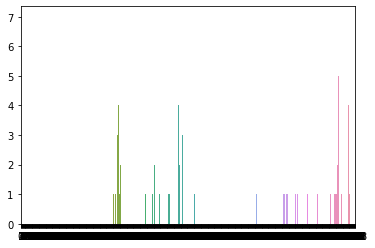

In [7]:
# threshold = 0
print(ov_func.AVG_EF_FN_ACRYNOMS[src_icn], "-->", ov_func.AVG_EF_FN_ACRYNOMS[dest_icn], f"between {src_phase} and {dest_phase}")

node_switch_counter = {}
src_list = np.ones(1054)*src_icn
dest_list = np.ones(1054)*dest_icn
nodes_count = np.zeros(1054)
x = []
avg_cat_per = []
for c in range(30):
    if c in ov_func.REMOVE:
        continue
    cycle_partitions = get_cycle_partitions(c)
    src_part = np.array(cycle_partitions[phase_to_int[src_phase]])
    dest_part = np.array(cycle_partitions[phase_to_int[dest_phase]])
    tar_mov = np.equal(src_part, src_list) * np.equal(dest_part, dest_list)
    mov_percent = sum(tar_mov)/sum(np.equal(src_part, src_list))
    x.append(mov_percent)

    print(f"Cycle {c}: {mov_percent*100:0.3}% moved ({sum(tar_mov)} / {sum(np.equal(src_part, src_list))} nodes)")

    node_switch_counter[c] = [i for i, t in enumerate(tar_mov) if t == True]
    nodes_count[node_switch_counter[c]] += 1

# myFunc.save_to_pickle(node_switch_counter, PICKLE_PATH, f'ddROI {ov_func.AVG_EF_FN_ACRYNOMS[src_icn]} {ov_func.AVG_EF_FN_ACRYNOMS[dest_icn]}.pkl')

print("Avg move %:", sum(x)/len(x))
print("Max frequency: ", max(nodes_count))
sns.barplot([i for i in range(1054)], nodes_count)
nodes_count_filtered = [x if x > 1 else 0 for x in nodes_count ]
print(np.count_nonzero(nodes_count_filtered))
ddROIs = list(np.nonzero(nodes_count_filtered)[0])
print(ddROIs)
# myFunc.save_to_pickle(ddROIs, PICKLE_PATH, f'switching_nodes.pkl')


# Create Gradient LUT files

For the set of all switching nodes (nodes_count), export it's LUT file. This file can be loaded into free surfer to
look at the nodes that switched in the branch overlayed on a brain surface image. Within free surfer, this image can
be compared to another atlas to identify which ROIs the most consistent switching nodes belong to.

In [8]:
importlib.reload(surfer)
surfer.export_cortical_surfer_lut_gradient(src_icn, nodes_count, f"{ov_func.AVG_EF_FN_ACRYNOMS[src_icn]} to "
                                                   f"{ov_func.AVG_EF_FN_ACRYNOMS[dest_icn]} between "
                                                   f"{src_phase} {dest_phase}", plot_colors=True)
surfer.export_subcortical_surfer_lut_gradient(src_icn, nodes_count, f"{ov_func.AVG_EF_FN_ACRYNOMS[src_icn]} to "
                                                   f"{ov_func.AVG_EF_FN_ACRYNOMS[dest_icn]} between "
                                                   f"{src_phase} {dest_phase}")

FileNotFoundError: [Errno 2] No such file or directory: '../Ovarian_hormone/Brain_Atlas/Schaefer2018_1000Parcels_7Networks_order.txt'

---
# Check consistency across cycles of dd-Functional Regions of Interest
- [X] DLPFC: 11 cycles showed switching. 10 cycles for right, 7 cycles for left
        - Not enforcing src and dest FN assignment but only phase transition: 18 cycles switched, 15 L, 18 R.
- [X] dorsal MCC: 7 cycles showed switching. 5 cycles for right, 5 cycles for left
        - Not enforcing src and dest FN assignment but only phase transition: 19 cycles switched, 15 L, 16 R.
- [X] precuneus Left: 3 cycles showed switching. 3 cycles for left, dne for right
        - Not enforcing src and dest FN assignment but only phase transition: 16 cycles switched, 16 L, n/a R.
- [X] dorsal PCC: 9 cycles showed switching. 8 cycles for right, 7 cycles for left
        - Not enforcing src and dest FN assignment but only phase transition: 19 cycles switched, 17 L, 18 R.
- [X] angular gyrus: 7 cycles showed switching. 5 cycles for right, 5 cycles for left
        - Not enforcing src and dest FN assignment but only phase transition: 12 cycles switched, 11 L, 11 R.

In [9]:
joes_list =  {"r": [],
              "l": [1031]}
region_name = "Thalamus Left"

ddfrois = {"l": [x-1 for x in joes_list["l"]], "r": [x-1 for x in joes_list["r"]]}

src_phase = 'EF'
dest_phase = 'ML'
icn_pair = []

print(f"between {src_phase} and {dest_phase}")
# src_list = np.ones(1054)*0
# dest_list = np.ones(1054)*4
frequency_count = {"l": 0, "r": 0}
unique_cycles = set()
for c in range(30):
    if c in ov_func.REMOVE:
        continue
    cycle_partitions = get_cycle_partitions(c)
    src_part = np.array(cycle_partitions[phase_to_int[src_phase]])
    dest_part = np.array(cycle_partitions[phase_to_int[dest_phase]])
    # tar_mov = np.equal(src_part, src_list) * np.equal(dest_part, dest_list)
    tar_mov = np.invert(np.equal(src_part, dest_part))
    switching_nodes = set([i for i, t in enumerate(tar_mov) if t == True])
    # Do these switching nodes include nodes that belong to the region of interest?
    for s in ["l", "r"]:
        overlap = switching_nodes.intersection(ddfrois[s])
        if len(overlap) > 0:
            frequency_count[s] += 1
            unique_cycles.add(c)
            for node_id in overlap:
                icn_pair.append((src_part[node_id], dest_part[node_id]))
print(f"{region_name} Left switched in {frequency_count['l']} cycles")
print(f"{region_name} Right switched in {frequency_count['r']} cycles")
print(f"Total unique cycles: {len(unique_cycles)}")

between EF and ML
Thalamus Left Left switched in 10 cycles
Thalamus Left Right switched in 0 cycles
Total unique cycles: 10


After counting moves, see the distribution of the branches

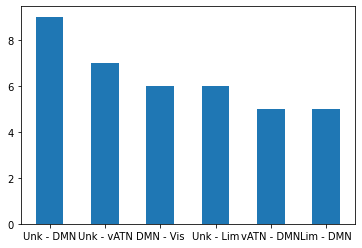

Unk --> DMN (9)
Unk --> vATN (7)
DMN --> Vis (6)
Unk --> Lim (6)
vATN --> DMN (5)
Lim --> DMN (5)


In [10]:
unique_branches = set(icn_pair)
branch_freq = []
for b in unique_branches:
    branch_freq.append((b, np.sum(np.equal(icn_pair, b))))
    # print(b, np.sum(np.equal(icn_pair, b)))
sorted_freq = sorted(branch_freq, key = lambda k: k[1], reverse=True)
top = 10
plt.bar([f"{ov_func.AVG_EF_FN_ACRYNOMS[k[0][0]]} - {ov_func.AVG_EF_FN_ACRYNOMS[k[0][1]]}" for k in sorted_freq[:top]],
        [k[1] for k in sorted_freq[:top]],
        [0.5 for _ in sorted_freq][:top], align='center')
plt.show()

for branch, count in sorted_freq[:top]:
    print(f"{ov_func.AVG_EF_FN_ACRYNOMS[branch[0]]} --> {ov_func.AVG_EF_FN_ACRYNOMS[branch[1]]} ({count})")

Show FN distribution as Pie chart

[[7. 1. 0. 2. 0. 4. 1. 0. 5.]
 [7. 0. 2. 4. 0. 2. 3. 0. 2.]
 [8. 1. 3. 2. 0. 5. 1. 0. 0.]]


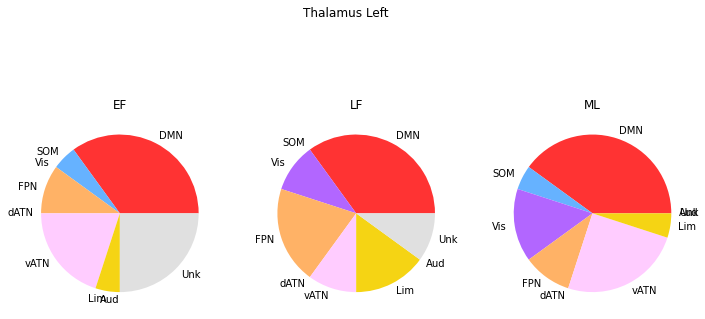

In [11]:
pie_data = np.zeros((3,9))
node_set = ddfrois['l'] + ddfrois['r']
# node_set = ddfrois['r']
n = len(node_set)

for c in range(30):
    if c in ov_func.REMOVE:
        continue
    cycle_partitions = get_cycle_partitions(c)
    for i, p in enumerate(cycle_partitions):
        cycle_mod_dict = Counter(np.array(p)[node_set])
        for mod, cu in cycle_mod_dict.items():
            pie_data[i][mod] += cu

print(pie_data/n)
fig, ax = plt.subplots(1,3,figsize=(12,6))
mylabels = list(ov_func.AVG_EF_FN_ACRYNOMS.values())
mycolors = list(ov_func.ICN_COLORS_HEX.values())
for i in range(3):
    ax[i].pie(pie_data[i], labels=mylabels, colors=mycolors)
    ax[i].set_title(int_to_phase[i])
plt.suptitle(region_name)
# fig.savefig(f"../Ovarian_hormone/Figures/ddROIs/{region_name} Lim EF ML pie.png", dpi=300, bbox_inches='tight')
plt.show()
